# Simple Bayes filter using discrete distributions

Problem setting: We have a dice (1-$n$ possibilities), want to filter out the noise from observations given the models: $X_t$ - face of the dice at time $t$,  $y_t$ (noisy) observation of the dice with a "discrete Gaussian noise". Then the conditional generative model can be written as

$$
\text{ (State process conditional model) } P(x_{t+1} | x_t) = \begin{cases}
    0.2 / (n-1) & \text{if } x_{t+1} \neq x_t \\
    0.8 & \text{otherwise}
\end{cases} 
\\
\text{(Observation model)} P(y_t | x_t) = \frac{1}{Z} (n - |y_t - x_t|) \text{(or alternatively)} = \frac{1}{Z} D(\mathcal N(x_t, \sigma^2))
,$$
where $D$ simply takes Normal density at fixed discrete interval.

We can integrate this information by writing out the Bayes filter:
$$
P(x_t | y_{1:t}) \propto P(x_t | y_{1:t-1}) P(y_t | x_t)
$$

Where the first term is the prediction step (the prior), and the second is the correction step (the likelihood), the latter of which we know how to compute already (up to normalization, which is easy to find due to discreteness). Similarly, we only care about this distribution up to normalization.

The first term is where the power of the filter lies. Writing it down by integrating the missing piece $x_{t-1}$
 
$$
    P(x_t | y_{1:t-1}) = \int P(x_t, x_{t-1} | y_{1:t-1}) dx_{t-1} = \int P(x_{t-1} | y_{1:t-1}) P(x_t | x_{t-1}) dx_{t-1},
$$
shows the recursive nature of the method. For each candidate $x_t$, we look at all possible histories' (elements $x_{t-1}$ that could've preceeded $x_t$) probabilities $p(x_t|x_{t-1})$, governed by our state process model, and weight it by our posterior from previous step $p(x_{t-1} | y_{1:t-1})$.

Note that $x_{t-1}$ is discrete, and so the integral amounts to a simple sum, which can be implemented simply

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
n = 10

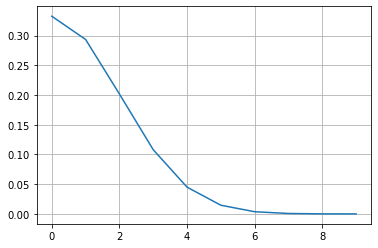

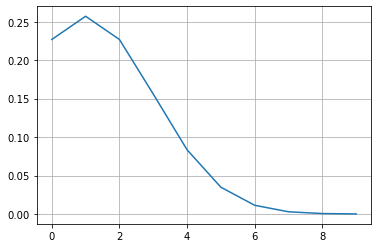

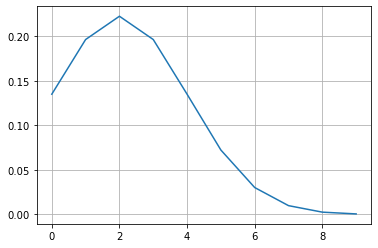

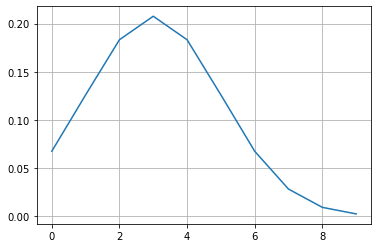

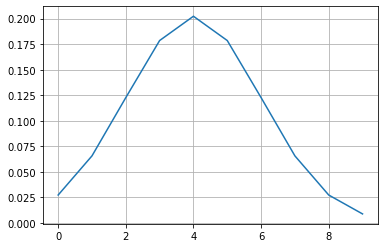

In [3]:
from scipy.stats import norm
# Calculate the discrete observational model probabilities
observational_probs = np.zeros((n, n)) # p(y_t | x_t)

for i in range(0, n):
    # observational_probs[i-1,:] = (n - np.abs(np.arange(1, n+1)  - i))
    observational_probs[i,:] = norm.pdf(np.arange(0, n), loc = i, scale=2)
    # normalize
    observational_probs[i, :] /= np.sum(observational_probs[i, :])

    if i < 5:
        plt.figure()
        plt.plot(observational_probs[i,:])
        plt.grid()
        plt.show()


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

blue, = sns.color_palette("muted", 1)

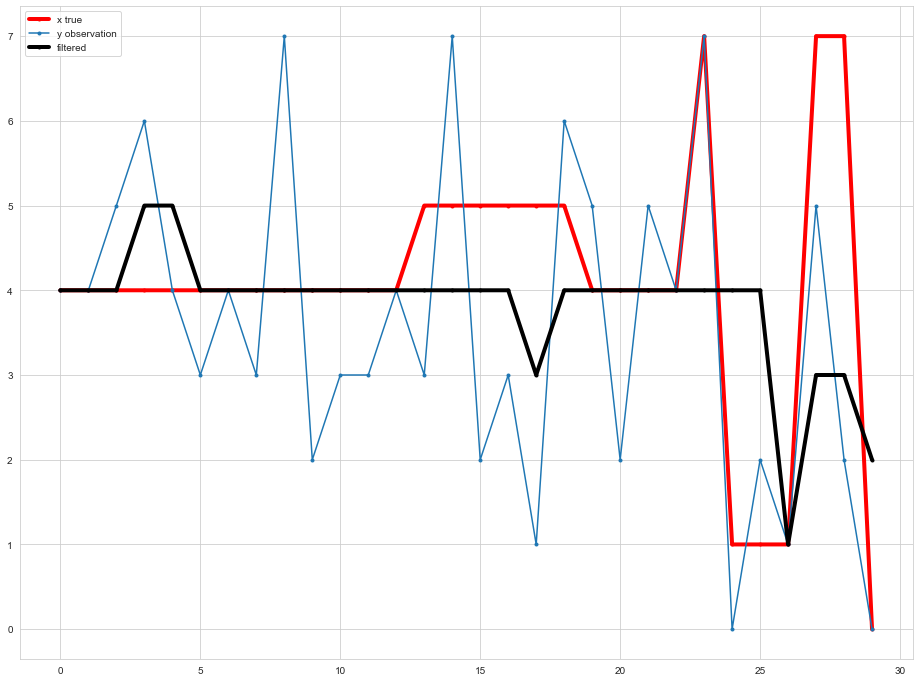

In [10]:

x_t = 4
prev_posterior = np.ones(n) / n # Assume uninformative prior initially!

x_ts = []
y_ts = []
filtered_ts = []
for i in range(30):
    x_t_true = np.random.randint(low=0, high=n) if np.random.random() < 0.2 else x_t 

    # sample from categorical based on x_t and observational noise
    y_t_obs = np.nonzero(np.random.multinomial(1, observational_probs[x_t_true,:], None))[0]

    p_t_posterior = np.zeros(n)  # p(y_t | x_t)

    for x_t_candidate in np.arange(0, n):
        # Compute a (predictive) probability distribution over this possible x_t candidate
        # i.e. P(x_t | y_{1:t-1})
        p_xt_given_xtn1 = np.ones(n) * (0.2 ) / (n-1)
        p_xt_given_xtn1[x_t_candidate] = 0.8

        predictive_prob_x_t_y_t_1 = np.sum(prev_posterior * (p_xt_given_xtn1))

        # Compute the correction probability (easy)
        # This is just the discrete Gaussian noise, it's already normalized
        correction_y_t = observational_probs[y_t_obs, x_t_candidate]
        
        p_t_posterior[x_t_candidate] = correction_y_t * predictive_prob_x_t_y_t_1
    # Normalize the posterior
    p_t_posterior /= np.sum(p_t_posterior)

    prev_posterior = p_t_posterior.copy()
    x_t = x_t_true

    x_ts.append(x_t)
    y_ts.append(y_t_obs)
    filtered_ts.append(np.argmax(p_t_posterior))
    # print(f"We observed {y_t_obs}") 

plt.figure(figsize=(16,12))
plt.plot(x_ts, ".-", label="x true", linewidth=4.0, color="red")
plt.plot(y_ts, ".-", label="y observation")
plt.plot(filtered_ts, ".-", label="filtered", linewidth=4.0, color="black")
plt.legend()
plt.show()
    